# VaR & CVaR based on Energy Factors - Montecarlo approach

In [89]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import seaborn as sns
import time
import cvxpy as cp
from scipy.optimize import minimize
import yfinance as yf
import warnings 
import tqdm
warnings.filterwarnings('ignore')

## Parametri

In [90]:
##storico totale
start_date  = '2010-01-01'
end_date    = '2023-06-30'
timeframe   = 'M'
rolling_p   = 6
std_mode    = 'max' #mean, median , max , q75, q90

stock_symb  = 'TSLA'
fact_symbs  = 'NG=F, CL=F, MTF=F, HO=F, ICLN, IXC, URA'
cv_folds    = 5

num_years   = 5
num_runs    = 25000

## Download

In [91]:
energy_factors = yf.download(fact_symbs,start=start_date, end=end_date)['Adj Close']
energy_factors = np.log1p(energy_factors.pct_change())

[*********************100%***********************]  7 of 7 completed


In [92]:
energy_factors

,CL=F,HO=F,ICLN,IXC,MTF=F,NG=F,URA
Date,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.003185,0.001642,0.026414,0.005423,NaN,-0.042885,NaN
2010-01-06,0.017097,0.004139,0.008511,0.008616,NaN,0.063906,NaN
2010-01-07,-0.006271,-0.008936,0.002117,-0.002954,NaN,-0.034366,NaN
2010-01-08,0.001088,0.007619,0.008840,0.003758,NaN,-0.009866,NaN
...,...,...,...,...,...,...,...
2023-06-23,-0.005048,-0.023972,-0.016732,-0.012205,-0.005636,0.045352,-0.025482
2023-06-26,0.003032,0.013083,0.002247,0.016881,-0.003048,0.022465,0.000938
2023-06-27,-0.024368,-0.016454,0.008939,-0.001923,0.000000,-0.010083,-0.005642


In [93]:
stock = yf.download(stock_symb,start=start_date, end=end_date)['Adj Close']
stock_last_prince = float(stock[-1])
stock = np.log1p(stock.pct_change())
stock.name = stock_symb
stock_last_prince

[*********************100%***********************]  1 of 1 completed


257.5

,CL=F,HO=F,ICLN,IXC,MTF=F,NG=F,URA,TSLA
Date,,,,,,,,
2010-12-20,0.008935,0.006367,-0.001978,0.008961,0.000000,0.041196,0.012177,0.010783
2010-12-21,0.011308,0.010747,0.012691,0.005527,0.006104,-0.042919,0.003524,0.017512
2010-12-22,0.007321,0.004797,0.000000,0.005497,0.018091,0.022653,-0.001005,0.011404
2010-12-23,0.011319,0.004853,-0.003790,0.003648,-0.001994,-0.016758,0.000000,-0.081039
2010-12-27,-0.005589,-0.009570,-0.002535,-0.001562,-0.001998,0.007077,-0.003023,-0.163556
...,...,...,...,...,...,...,...,...
2023-06-23,-0.005048,-0.023972,-0.016732,-0.012205,-0.005636,0.045352,-0.025482,-0.030739
2023-06-26,0.003032,0.013083,0.002247,0.016881,-0.003048,0.022465,0.000938,-0.062514
2023-06-27,-0.024368,-0.016454,0.008939,-0.001923,0.000000,-0.010083,-0.005642,0.037296


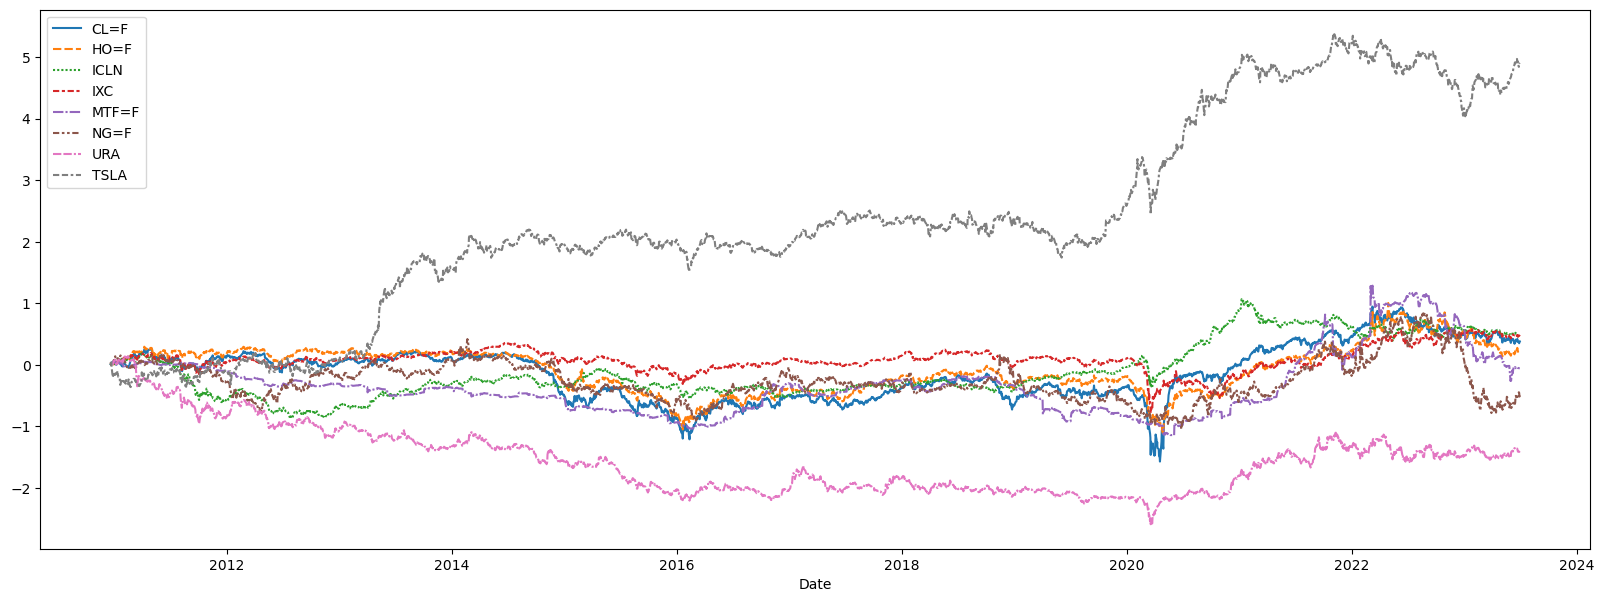

In [94]:
daily_data = pd.concat([energy_factors, stock], axis=1).dropna()
# data['SPY'] = data['SPY'].shift(-1)
plt.figure(figsize=(20,7))
sns.lineplot(daily_data.cumsum())
# data.cumsum().plot()
daily_data

## Utility Functions

In [95]:
def create_options():
    '''create standard options dictionary to be used as input to regression functions'''
    options = dict()
    options['time_period'] = 'all'
    options['date'] = 'Date'
    options['return_model'] = False
    options['print_loadings'] = True
    return options

def create_options_lasso():
    options = create_options()
    options['lambda_hat'] = .5
    return options

def create_options_cv_lasso():
    options = create_options()
    options['max_lambda_hat'] = 1
    options['n_lambda_hat'] = 250
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_cv_ridge():
    options = create_options()
    options['max_lambda'] = 1
    options['n_lambda'] = 250
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_cv_elastic_net():
    options = create_options()
    options['max_lambda_hat'] = 1
    options['max_l1_ratio'] = .99
    options['n_lambda_hat'] = 250
    options['n_l1_ratio'] = 20
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_best_subset():
    '''create standard options dictionary to be used as input to regression functions'''
    options = create_options()
    options['return_model'] = False
    options['print_loadings'] = True
    options['max_vars'] = 3
    return options

def num_to_month(month):
    #num to month returns the name of the month, input is an integer
    if (month==1):
        return 'January'
    if (month==2):
        return 'Febuary'
    if (month==3):
        return 'March'
    if (month==4):
        return 'April'
    if (month==5):
        return 'May'
    if (month==6):
        return 'June'
    if (month==7):
        return 'July'
    if (month==8):
        return 'August'
    if (month==9):
        return 'September'
    if (month==10):
        return 'October'
    if (month==11):
        return 'November'
    if (month==12):
        return 'December'

def display_factor_loadings(intercept, coefs, factorNames, options):
    '''display_factor_loadings takes an intercept, coefs, factorNames and options dict, and prints the factor loadings in a readable way
    INPUTS:
        intercept: float, intercept value
        coefs: np array, coeficients from pandas df
        factorNames: list, names of the factors
        options: dict, should contain at least one key, nameOfReg
            nameOfReg: string, name for the regression
    Outputs:
        output is printed
    '''
    loadings = np.insert(coefs, 0, intercept)
    if('name_of_reg' not in options.keys()):
        name = 'No Name'
    else:
        name = options['name_of_reg']
    out = pd.DataFrame(loadings, columns=[name])
    out = out.transpose()
    fullNames = ['Intercept'] + factorNames
    out.columns = fullNames
    print(out)

def print_timeperiod(data, dependentVar, options):
    '''print_timeperiod takes a a dependent varaible and a options dictionary, prints out the time period
    INPUTS:
        data: pandas df, df with the data
        dependentVar: string, name of dependent variable
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
    OUTPUTS:
        printed stuff
    '''
    print ('Dependent Variable is ' + dependentVar)
    if(options['time_period'] == 'all'):
        sortedValues = data.sort_values(options['date'])[options['date']].reset_index(drop=True)
        n = sortedValues.shape[0]
        beginDate = sortedValues[0]
        endDate = sortedValues[n-1]
        print ('Time period is between ' + num_to_month(beginDate.month) +  ' ' + str(beginDate.year) + ' to ' + num_to_month(endDate.month) +  ' ' + str(endDate.year) + ' inclusive   ')        
    else:
        print ('Time period is ' + options['timeperiod'])

def linear_regression(data, dependentVar, factorNames, options):
    '''linear_regression takes in a dataset and returns the factor loadings using least squares regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #first filter down to the time period
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    linReg = LinearRegression(fit_intercept=True)
    linReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        # Now print the factor loadings
        display_factor_loadings(linReg.intercept_, linReg.coef_, factorNames, options)

    if(options['return_model']):
        return linReg
      
def lasso_regression(data, dependentVar, factorNames, options):
    '''lasso_regression takes in a dataset and returns the factor loadings using lasso regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            printLoadings: boolean, if true, prints the coeficients

            date: name of datecol
            returnModel: boolean, if true, returns model
            alpha: float, alpha value for LASSO regression
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    if('lambda_hat' not in options.keys()):
        print ('lambda_hat not specified in options')
        return

    #first filter down to the time period
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    lassoReg = Lasso(alpha=options['lambda_hat'], fit_intercept=True)
    lassoReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('lambda_hat = ' + str(options['lambda_hat']))

        #Now print the factor loadings
        display_factor_loadings(lassoReg.intercept_, lassoReg.coef_, factorNames, options)
        
def cross_validated_lasso_regression(data, dependentVar, factorNames, options):
    '''cross_validated_lasso_regression takes in a dataset and returns the factor loadings using lasso regression and cross validating the choice of lambda
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphas = np.logspace(-12, np.log(options['max_lambda_hat']), base=np.exp(1), num=options['n_lambda_hat'])
    #alphas = np.linspace(1e-12, alphaMax, options['nAlphas'])
    if(options['random_state'] == 'none'):
        lassoTest = Lasso(fit_intercept=True)
    else:
        lassoTest = Lasso(random_state = options['random_state'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas}]

    clf = GridSearchCV(lassoTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    lassoBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best lambda_hat = ' + str(alphaBest))
        #Now print the factor loadings
        display_factor_loadings(lassoBest.intercept_, lassoBest.coef_, factorNames, options)

    if(options['return_model']):
        return lassoBest
    
def cross_validated_ridge_regression(data, dependentVar, factorNames, options):
    '''cross_validated_ridge_regression takes in a dataset and returns the factor loadings using ridge regression and choosing lambda via ridge regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  So I change Lambda -> Alpha in the following code
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphaMax = options['max_lambda']
    alphas = np.logspace(-12, np.log(alphaMax), num=options['n_lambda'], base=np.exp(1))
    if(options['randomState'] == 'none'):
        ridgeTest = Ridge(fit_intercept=True)
    else:
        ridgeTest = Ridge(random_state = options['randomState'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas}]

    clf = GridSearchCV(ridgeTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    ridgeBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best Lambda = ' + str(alphaBest))
        #Now print the factor loadings
        display_factor_loadings(ridgeBest.intercept_, ridgeBest.coef_, factorNames, options)

    if(options['return_model']):
        return ridgeBest

def cross_validated_elastic_net_regression(data, dependentVar, factorNames, options):
    '''cross_validated_elastic_net_regression takes in a dataset and returns the factor loadings using elastic net, also chooses alpha and l1 ratio via cross validation
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            maxL1Ratio: float
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  So I change Lambda -> Alpha in the following code
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphaMax = options['max_lambda_hat']
    alphas = np.logspace(-12, np.log(alphaMax), num=options['n_lambda_hat'])
    l1RatioMax = options['max_l1_ratio']
    l1Ratios = np.linspace(1e-6, l1RatioMax, options['n_l1_ratio'])
    if(options['random_state'] == 'none'):
        elasticNetTest = ElasticNet(fit_intercept=True)
    else:
        elasticNetTest = ElasticNet(random_state = options['random_state'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas, 'l1_ratio': l1Ratios}]

    clf = GridSearchCV(elasticNetTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    elasticNetBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']
    l1RatioBest = clf.best_params_['l1_ratio']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best lambda_hat = ' + str(alphaBest))
        print('Best l1 ratio = ' + str(l1RatioBest))
        #Now print the factor loadings
        display_factor_loadings(elasticNetBest.intercept_, elasticNetBest.coef_, factorNames, options)

    if(options['return_model']):
        return elasticNetBest

def best_subset(x,y,l_0):
    # Mixed Integer Programming in feature selection
    M = 1000
    n_factor = x.shape[1]
    z = cp.Variable(n_factor, boolean=True)
    beta = cp.Variable(n_factor)
    alpha = cp.Variable(1)

    def MIP_obj(x,y,b,a):
        return cp.norm(y-cp.matmul(x,b)-a,2)

    best_subset_prob = cp.Problem(cp.Minimize(MIP_obj(x, y, beta, alpha)), 
                             [cp.sum(z)<=l_0, beta+M*z>=0, M*z>=beta])
    best_subset_prob.solve(solver='ECOS_BB')
    return alpha.value, beta.value

def best_subset_regression(data, dependentVar, factorNames, options):
    '''best_subset_regression takes in a dataset and returns the factor loadings using best subset regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            maxVars: int, maximum number of factors that can have a non zero loading in the resulting regression
            printLoadings: boolean, if true, prints the coeficients
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Check dictionary for maxVars option
    if('max_vars' not in options.keys()):
        print ('max_vars not specified in options')
        return

    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    alpha, beta = best_subset(data[factorNames].values, data[dependentVar].values, options['max_vars'])
    #round beta values to zero
    beta[np.abs(beta) <= 1e-7] = 0.0
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Max Number of Non-Zero Variables is ' + str(options['max_vars']))

        #Now print the factor loadings
        display_factor_loadings(alpha, beta, factorNames, options)

    if(options['return_model']):
        out = LinearRegression()
        out.intercept_ = alpha[0]
        out.coef_ = beta
        return out


## DATA

In [96]:
resampled_data = daily_data.copy()
resampled_data.dropna(how='any', inplace=True)

if timeframe == 'W':
    resampled_data = resampled_data.resample('W').sum()
elif timeframe == 'M':
    resampled_data = resampled_data.resample('M').sum()
elif timeframe == 'Q':
    resampled_data = resampled_data.resample('Q').sum()

resampled_data.dropna(how='any', inplace=True)
factors = resampled_data.drop(stock_symb, axis=1).columns.tolist()
resampled_data.reset_index(inplace=True)
resampled_data.rename(columns={'index': 'Date'}, inplace=True)

# Continue with the rest of your code using the resampled_data
resampled_data

,Date,CL=F,HO=F,ICLN,IXC,MTF=F,NG=F,URA,TSLA
0,2010-12-31,0.037463,0.027905,0.011818,0.039372,0.074691,0.080081,0.063494,-0.163495
1,2011-01-31,0.008825,0.076817,0.040216,0.058423,-0.101580,0.003399,0.019353,-0.099826
2,2011-02-28,0.050550,0.063131,0.040991,0.061349,0.006270,-0.090638,0.000958,-0.008752
3,2011-03-31,0.095807,0.054538,0.092767,0.008818,0.060625,0.083600,-0.341271,0.149776
4,2011-04-30,0.065376,0.052332,-0.025794,0.022043,0.002741,0.068035,-0.037740,-0.005420
...,...,...,...,...,...,...,...,...,...
146,2023-02-28,-0.023346,-0.120548,-0.077154,-0.050744,0.066916,0.023201,-0.095614,0.171905
147,2023-03-31,-0.018073,-0.052621,0.029761,-0.012370,-0.054181,-0.214806,-0.048957,0.008471
148,2023-04-30,0.014562,-0.117881,-0.055613,0.040483,0.014643,0.083923,0.003506,-0.233184
149,2023-05-31,-0.120114,-0.051366,-0.019974,-0.102201,-0.389139,-0.061611,-0.005515,0.216022


In [97]:
factors

['CL=F', 'HO=F', 'ICLN', 'IXC', 'MTF=F', 'NG=F', 'URA']

In [98]:
resampled_data = resampled_data.copy()

for factor in factors:
    resampled_data[f'{factor}_shift1'] = resampled_data[factor].shift(1)
    # resampled_data[f'{factor}_shift2'] = resampled_data[factor].shift(2)

resampled_data.dropna(inplace=True)
factors = resampled_data.drop([stock_symb, 'Date'], axis=1).columns.tolist()
resampled_data.dropna(inplace=True)
resampled_data

,Date,CL=F,HO=F,ICLN,IXC,MTF=F,NG=F,URA,TSLA,CL=F_shift1,HO=F_shift1,ICLN_shift1,IXC_shift1,MTF=F_shift1,NG=F_shift1,URA_shift1
1,2011-01-31,0.008825,0.076817,0.040216,0.058423,-0.101580,0.003399,0.019353,-0.099826,0.037463,0.027905,0.011818,0.039372,0.074691,0.080081,0.063494
2,2011-02-28,0.050550,0.063131,0.040991,0.061349,0.006270,-0.090638,0.000958,-0.008752,0.008825,0.076817,0.040216,0.058423,-0.101580,0.003399,0.019353
3,2011-03-31,0.095807,0.054538,0.092767,0.008818,0.060625,0.083600,-0.341271,0.149776,0.050550,0.063131,0.040991,0.061349,0.006270,-0.090638,0.000958
4,2011-04-30,0.065376,0.052332,-0.025794,0.022043,0.002741,0.068035,-0.037740,-0.005420,0.095807,0.054538,0.092767,0.008818,0.060625,0.083600,-0.341271
5,2011-05-31,-0.103772,-0.063233,-0.076330,-0.049892,-0.045608,-0.006835,-0.060537,0.088037,0.065376,0.052332,-0.025794,0.022043,0.002741,0.068035,-0.037740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2023-02-28,-0.023346,-0.120548,-0.077154,-0.050744,0.066916,0.023201,-0.095614,0.171905,-0.004743,-0.058456,0.043860,0.031059,-0.512216,-0.569704,0.137073
147,2023-03-31,-0.018073,-0.052621,0.029761,-0.012370,-0.054181,-0.214806,-0.048957,0.008471,-0.023346,-0.120548,-0.077154,-0.050744,0.066916,0.023201,-0.095614
148,2023-04-30,0.014562,-0.117881,-0.055613,0.040483,0.014643,0.083923,0.003506,-0.233184,-0.018073,-0.052621,0.029761,-0.012370,-0.054181,-0.214806,-0.048957
149,2023-05-31,-0.120114,-0.051366,-0.019974,-0.102201,-0.389139,-0.061611,-0.005515,0.216022,0.014562,-0.117881,-0.055613,0.040483,0.014643,0.083923,0.003506


In [99]:
factors

['CL=F',
 'HO=F',
 'ICLN',
 'IXC',
 'MTF=F',
 'NG=F',
 'URA',
 'CL=F_shift1',
 'HO=F_shift1',
 'ICLN_shift1',
 'IXC_shift1',
 'MTF=F_shift1',
 'NG=F_shift1',
 'URA_shift1']

## OLS Regression

In [100]:
options = create_options()
options['name_of_reg'] = 'OLS full data'
options['return_model'] = True
ols_model_train = linear_regression(resampled_data, stock_symb, factors, options)

Dependent Variable is TSLA
Time period is between January 2011 to June 2023 inclusive   
               Intercept      CL=F     HO=F      ICLN       IXC     MTF=F  \
OLS full data   0.036963  0.342978 -0.09692  0.817319 -0.480824 -0.130323   

                   NG=F       URA  CL=F_shift1  HO=F_shift1  ICLN_shift1  \
OLS full data  0.114027  0.140985    -0.024494     0.264998      0.00003   

               IXC_shift1  MTF=F_shift1  NG=F_shift1  URA_shift1  
OLS full data   -0.473653     -0.071522     0.014534    0.212128  


## Penalized Regressions (Lasso , Elastic Net)

In [101]:
options = create_options_cv_lasso()
options['name_of_reg'] = 'CV Lasso'
options['max_lambda_hat'] = .01 #This specifies the maximum Alpha value tested by cross validation, minimum value is zero
options['return_model'] = True
options['n_folds'] = cv_folds 
lasso_model_train = cross_validated_lasso_regression(resampled_data, stock_symb, factors, options)

Dependent Variable is TSLA
Time period is between January 2011 to June 2023 inclusive   
Best lambda_hat = 0.0017339403933301183
          Intercept      CL=F  HO=F      ICLN  IXC  MTF=F      NG=F  URA  \
CV Lasso   0.031828  0.061848  -0.0  0.613258  0.0   -0.0  0.011186  0.0   

          CL=F_shift1  HO=F_shift1  ICLN_shift1  IXC_shift1  MTF=F_shift1  \
CV Lasso         -0.0          0.0          0.0        -0.0          -0.0   

          NG=F_shift1  URA_shift1  
CV Lasso         -0.0         0.0  


In [102]:
options = create_options_cv_elastic_net()
options['name_of_reg'] = 'CV Elastic Net'
options['max_lambda_hat'] = .01
options['return_model'] = True
options['n_folds'] = cv_folds
en_model_train = cross_validated_elastic_net_regression(resampled_data, stock_symb, factors, options)

Dependent Variable is TSLA
Time period is between January 2011 to June 2023 inclusive   
Best lambda_hat = 2.4821602362195342e-05
Best l1 ratio = 0.99
                Intercept      CL=F      HO=F      ICLN       IXC     MTF=F  \
CV Elastic Net   0.036776  0.330804 -0.096774  0.812561 -0.451627 -0.126496   

                   NG=F       URA  CL=F_shift1  HO=F_shift1  ICLN_shift1  \
CV Elastic Net  0.11176  0.135461    -0.017068     0.249362         -0.0   

                IXC_shift1  MTF=F_shift1  NG=F_shift1  URA_shift1  
CV Elastic Net   -0.460186     -0.067065     0.011603    0.208395  


In [103]:
en_model_train.score

<bound method RegressorMixin.score of ElasticNet(alpha=2.4821602362195342e-05, l1_ratio=0.99, random_state=7777)>

In [104]:
intercept = en_model_train.intercept_
betas = en_model_train.coef_
betas = betas.tolist()

In [105]:
pd.DataFrame(betas , index=factors).sort_index()

,0
CL=F,0.330804
CL=F_shift1,-0.017068
HO=F,-0.096774
HO=F_shift1,0.249362
ICLN,0.812561
ICLN_shift1,-0.000000
IXC,-0.451627
IXC_shift1,-0.460186
MTF=F,-0.126496
MTF=F_shift1,-0.067065


## VIF Collinearity

In [106]:
# the independent variables set
X = resampled_data[factors]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
						for i in range(len(X.columns))]

print(vif_data.sort_values('VIF', ascending=False))


         feature       VIF
7    CL=F_shift1  3.792398
3            IXC  3.517615
0           CL=F  3.354250
10    IXC_shift1  3.051990
8    HO=F_shift1  2.998095
1           HO=F  2.771902
9    ICLN_shift1  1.655487
2           ICLN  1.620147
13    URA_shift1  1.615170
6            URA  1.592322
5           NG=F  1.455262
4          MTF=F  1.403679
11  MTF=F_shift1  1.339149
12   NG=F_shift1  1.312312


## Dataset for Montecarlo

In [107]:
# Retrieve the historical data
df_factors = resampled_data.drop(['Date',stock_symb], axis=1).dropna()

# Compute mean returns for each factor
mean_returns = df_factors.mean()

# Compute the rolling volatility
rolling_volatility = df_factors.rolling(window=rolling_p).std()

# Compute the maximum rolling volatility over the last 15 years for each factor
if std_mode == 'median':
    _rolling_volatility = rolling_volatility.median()
elif std_mode == 'mean':
    _rolling_volatility = rolling_volatility.mean()
elif std_mode == 'max':
    _rolling_volatility = rolling_volatility.max()
elif std_mode == 'q75':
    _rolling_volatility = rolling_volatility.quantile(0.75) 
elif std_mode == 'q90':
    _rolling_volatility = rolling_volatility.quantile(0.90) 

# Store the maximum rolling volatility for each factor in sigmas_list
sigmas_list = _rolling_volatility.tolist()

mean_returns_list = mean_returns.tolist()

print("Mean Returns:", mean_returns_list)
print("Rolling Volatility:", sigmas_list)

Mean Returns: [0.002283875035543958, 0.0012607174180596882, 0.0030574666438658972, 0.0029895940021234086, -0.0008659495306050188, -0.0037590184410695483, -0.0097742425614427, 0.0023720888910238967, 0.000988723766999842, 0.0032348598447264386, 0.002855784685653205, -0.0016143773739716268, -0.00436368935239893, -0.009866753763579143]
Rolling Volatility: [0.5168136657401872, 0.25028041501644865, 0.16997654526624437, 0.1939755146744298, 0.39663557000568384, 0.3095695545261821, 0.23139896602351728, 0.5168136657401872, 0.25028041501644865, 0.16997654526624442, 0.1939755146744298, 0.39663557000568384, 0.3095695545261821, 0.23139896602351728]


## Montecarlo simulation

Generating future stock prices: 100%|██████████| 59/59 [00:07<00:00,  7.67it/s]


TSLA: next 5 years | 25000 iterations
Energy Factors: ['CL=F', 'HO=F', 'ICLN', 'IXC', 'MTF=F', 'NG=F', 'URA', 'CL=F_shift1', 'HO=F_shift1', 'ICLN_shift1', 'IXC_shift1', 'MTF=F_shift1', 'NG=F_shift1', 'URA_shift1']
VaR: -45.74%
CVaR: -57.12%


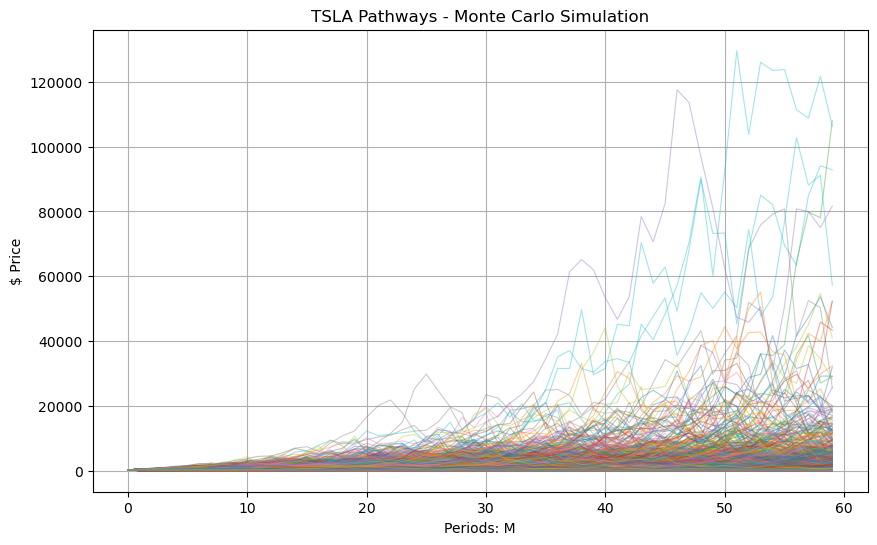

In [108]:
if timeframe=='D':
    n_steps = num_years * 252
elif timeframe=='W':
    n_steps = num_years * 52
elif timeframe=='M':
    n_steps = num_years * 12
elif timeframe=='Q':
    n_steps = num_years * 4


initial_stock_price = float(stock_last_prince)  
np.random.seed(42)

#Brownian motion
brownian_motion_paths = []
for i in range(len(mean_returns_list)):
    brownian_motion_path = np.random.normal(mean_returns_list[i], sigmas_list[i], size=(num_runs, n_steps))
    brownian_motion_paths.append(brownian_motion_path)

# Generate future stock prices
future_stock_prices = np.zeros((num_runs, n_steps))
future_stock_prices[:, 0] = initial_stock_price  

for i in tqdm.tqdm(range(1, n_steps), desc='Generating future stock prices'):
    for j in range(num_runs):
        energy_factor_returns = np.dot([brownian_motion_paths[k][j, i-1] for k in range(len(mean_returns_list))], betas)
        future_stock_price = future_stock_prices[j, i-1] * (1 + energy_factor_returns)
        future_stock_prices[j, i] = max(future_stock_price, 0.0)


# Compute stock returns
stock_returns = np.diff(future_stock_prices, axis=1) / future_stock_prices[:, :-1]
stock_returns = stock_returns[~np.isnan(stock_returns).any(axis=1)]
# Calculate VaR and CVaR 
confidence_level = 0.95
var = np.percentile(stock_returns, (1 - confidence_level) * 100)
cvar = np.mean(stock_returns[stock_returns <= var])

print(f'{stock_symb}: next {num_years} years | {num_runs} iterations')
print(f'Energy Factors: {factors}')
print("VaR:", "{:.2f}%".format(var * 100))
print("CVaR:", "{:.2f}%".format(cvar * 100))


# Plot stock pathways
plt.figure(figsize=(10, 6))
for i in range(num_runs):
    plt.plot(range(n_steps), future_stock_prices[i], linewidth=0.8, alpha=0.4)

plt.xlabel(f'Periods: {timeframe}')
plt.ylabel('$ Price')
plt.title(f'{stock_symb} Pathways - Monte Carlo Simulation')
plt.grid(True)
plt.show()

## VaR and CVaR Plots

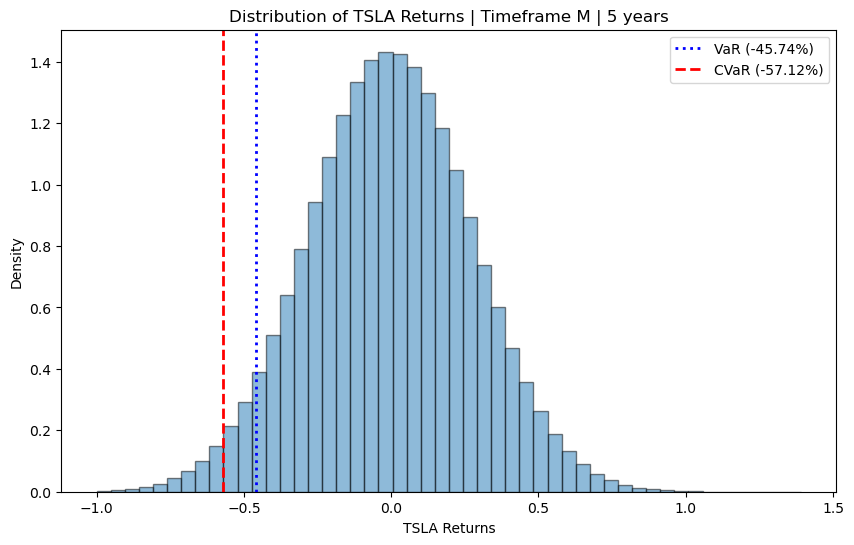

In [109]:
# Plot the distribution of returns
plt.figure(figsize=(10, 6))
plt.hist(stock_returns.flatten(), bins=50, density=True, edgecolor='k', alpha=0.5)
plt.xlabel(f'{stock_symb} Returns')
plt.ylabel('Density')
plt.title(f'Distribution of {stock_symb} Returns | Timeframe {timeframe} | {num_years} years')

# Format VaR and CVaR as percentages with two decimal points
var_formatted = "{:.2f}%".format(var * 100)
cvar_formatted = "{:.2f}%".format(cvar * 100)

# Plot vertical lines for VaR and CVaR with formatted values in the legend
plt.axvline(var, color='blue', linestyle='dotted', linewidth=2, label=f'VaR ({var_formatted})')
plt.axvline(cvar, color='red', linestyle='--', linewidth=2, label=f'CVaR ({cvar_formatted})')

# Add legend
plt.legend()

# Show the plot
plt.show()

